In [1]:
INSTALL_PACKAGES = False

# we're going to use tensorflow 2.14.0 and keras 2.14.0 because that's probably what the tutorial used
# https://developer.apple.com/metal/tensorflow-plugin/
# KerasCV installation: https://keras.io/keras_cv/#keras-2-installation
if INSTALL_PACKAGES:
    !pip install tensorflow==2.14.0 tensorflow-metal keras-cv opencv-python pycocotools matplotlib

In [2]:
# setup
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

Using TensorFlow backend


# Load Data

In [3]:
# hyperparameters
#SCALE_MAX = 1.3
#SCALE_MIN = 0.75
SCALE_MAX = 1.0
SCALE_MIN = 1.0
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCHS = 50
GLOBAL_CLIPNORM = 10.0

In [4]:
# map class names to unique integer identifier
global_class_ids = [
    "Bud",
#    "Leaf",
    "Stem",
]
class_mapping = dict(zip(range(len(global_class_ids)), global_class_ids))
class_mapping_values = class_mapping.values()

print(f'class_mapping: {class_mapping}')

# Path to images and annotations
path_annot = "data/annotations/"
path_images = "data/images/"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpeg")
    ]
)

class_mapping: {0: 'Bud', 1: 'Stem'}


In [5]:
# export PascalVOC images + annotations from Label Studio

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text

        if not cls in class_mapping_values:
            continue
        
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    if len(set(class_ids)) == len(class_mapping_values):
        image_paths.append(image_path)
        bbox.append(boxes)
        classes.append(class_ids)

#print(classes)
#print(bbox)

  0%|          | 0/28 [00:00<?, ?it/s]

In [6]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

2024-05-19 21:32:27.967433: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-05-19 21:32:27.967457: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-05-19 21:32:27.967460: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-05-19 21:32:27.967502: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-19 21:32:27.967520: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [8]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [9]:
# Resizes images to 640x640 while maintaining aspect ratio.
# The bounding boxes associated with the image are specified in the xyxy format.
# If necessary, the resized image will be padded with zeros to maintain the original aspect ratio.

augmenter = keras.Sequential(
    layers=[
#        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
#        keras_cv.layers.RandomShear(
#            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
#        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(SCALE_MIN, SCALE_MAX),
            bounding_box_format="xyxy"
        ),
    ]
)

# Creating Training Dataset

In [10]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

# Creating Validation Dataset

In [11]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(SCALE_MIN, SCALE_MAX),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

# Visualization

2024-05-19 21:32:30.607811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


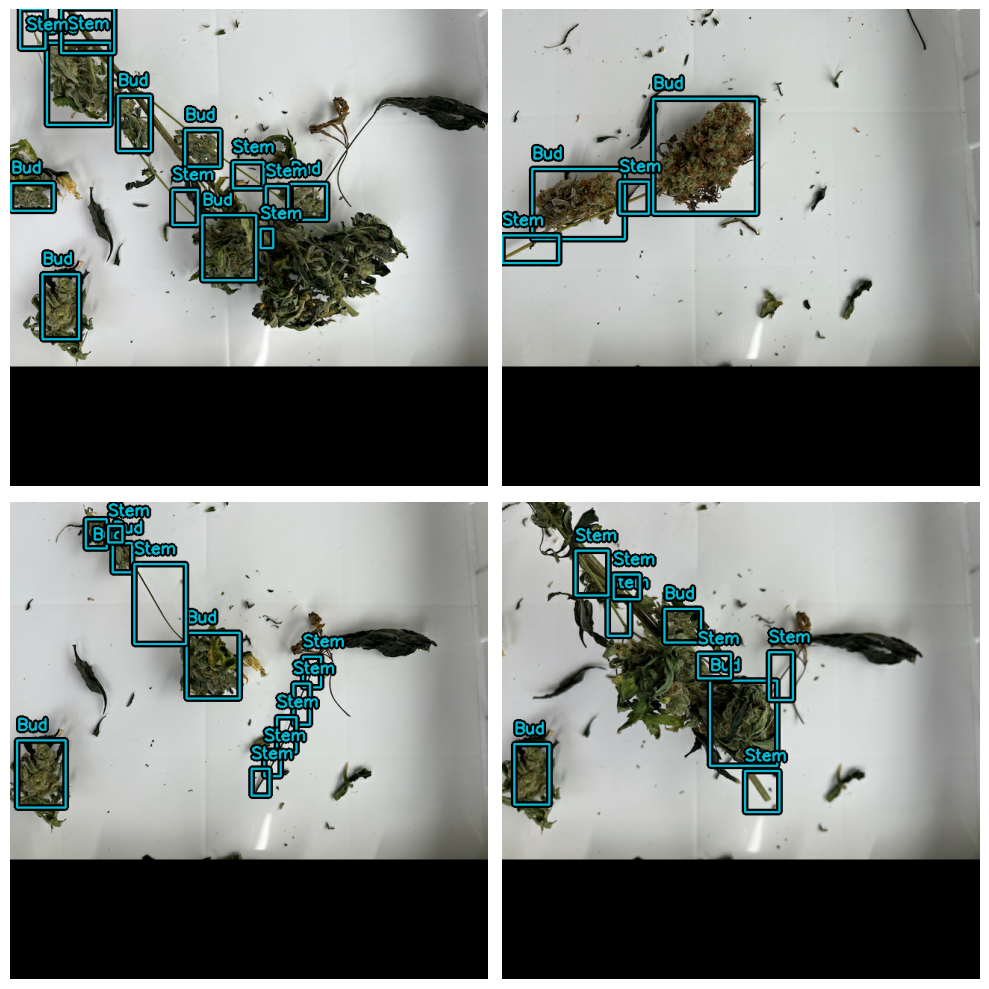

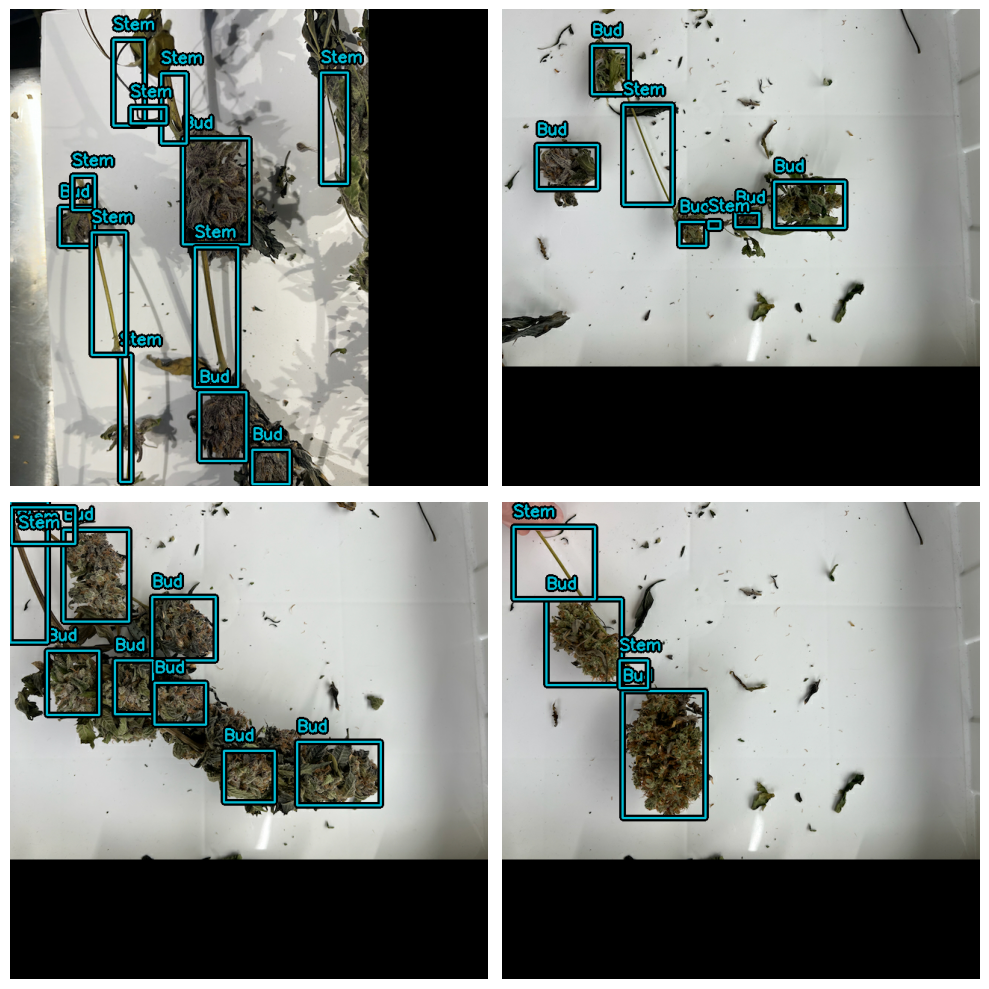

In [12]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [13]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Create The Model

In [14]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [15]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

# Compile the Model

In [16]:
# using optimizers.legacy.Adam instead of optimizers.Adam because of this message:
#
# WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs,
# please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.

optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [17]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path, save_format="tf")  # Save the model when mAP improves

        return logs

# Train the Model

In [18]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.tf")],
)

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 220.6783 - box_loss: 3.6166 - class_loss: 217.0617

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self.

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 50s 9s/step - loss: 220.6783 - box_loss: 3.6166 - class_loss: 217.0617 - val_loss: 670.1197 - val_box_loss: 3.9362 - val_class_loss: 666.1835 - MaP: 3.0003e-05 - MaP@[IoU=50]: 1.5001e-04 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 3.1117e-04 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0071 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0100 - Recall@[area=large]: 0.0000e+00
Epoch 2/50
5/5 [==============================] - ETA: 0s - loss: 129.8070 - box_loss: 3.1789 - class_loss: 126.6281

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 34s 8s/step - loss: 129.8070 - box_loss: 3.1789 - class_loss: 126.6281 - val_loss: 3330.3369 - val_box_loss: 4.1540 - val_class_loss: 3326.1829 - MaP: 2.6922e-04 - MaP@[IoU=50]: 0.0010 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 3.2307e-04 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0114 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0147 - Recall@[area=large]: 0.0000e+00
Epoch 3/50
5/5 [==============================] - ETA: 0s - loss: 99.0898 - box_loss: 3.2608 - class_loss: 95.8290 

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 33s 8s/step - loss: 99.0898 - box_loss: 3.2608 - class_loss: 95.8290 - val_loss: 4621.2124 - val_box_loss: 4.4643 - val_class_loss: 4616.7480 - MaP: 4.0243e-04 - MaP@[IoU=50]: 8.6440e-04 - MaP@[IoU=75]: 6.3198e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 5.4277e-04 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0184 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0269 - Recall@[area=large]: 0.0000e+00
Epoch 4/50
5/5 [==============================] - 8s 1s/step - loss: 84.7196 - box_loss: 3.2759 - class_loss: 81.4437 - val_loss: 3279.0195 - val_box_loss: 4.9163 - val_class_loss: 3274.1033 - MaP: 8.5109e-06 - MaP@[IoU=50]: 8.5109e-05 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 1.2766e-05 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 35s 8s/step - loss: 5.5639 - box_loss: 2.4184 - class_loss: 3.1455 - val_loss: 11.2383 - val_box_loss: 3.4544 - val_class_loss: 7.7838 - MaP: 0.0021 - MaP@[IoU=50]: 0.0124 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0109 - MaP@[area=large]: 5.2599e-04 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0147 - Recall@[max_detections=100]: 0.0382 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0500 - Recall@[area=large]: 0.0167
Epoch 25/50
5/5 [==============================] - 9s 2s/step - loss: 5.3099 - box_loss: 2.4910 - class_loss: 2.8189 - val_loss: 9.1356 - val_box_loss: 3.6956 - val_class_loss: 5.4400 - MaP: 0.0012 - MaP@[IoU=50]: 0.0032 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0173 - MaP@[area=large]: 7.7685e-04 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0147 - Recall@[max_detections=100]: 0.0441 - Recall@

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 34s 8s/step - loss: 4.9252 - box_loss: 2.4125 - class_loss: 2.5127 - val_loss: 9.6724 - val_box_loss: 3.4710 - val_class_loss: 6.2015 - MaP: 0.0031 - MaP@[IoU=50]: 0.0133 - MaP@[IoU=75]: 1.2825e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0116 - MaP@[area=large]: 0.0018 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0682 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0765 - Recall@[area=large]: 0.0667
Epoch 27/50
5/5 [==============================] - ETA: 0s - loss: 4.5130 - box_loss: 2.3342 - class_loss: 2.1787

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 32s 8s/step - loss: 4.5130 - box_loss: 2.3342 - class_loss: 2.1787 - val_loss: 7.5602 - val_box_loss: 3.4213 - val_class_loss: 4.1389 - MaP: 0.0084 - MaP@[IoU=50]: 0.0412 - MaP@[IoU=75]: 0.0018 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0096 - MaP@[area=large]: 0.0231 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0364 - Recall@[max_detections=100]: 0.0932 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.1029 - Recall@[area=large]: 0.1000
Epoch 28/50
5/5 [==============================] - ETA: 0s - loss: 4.2664 - box_loss: 2.2276 - class_loss: 2.0388

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 35s 8s/step - loss: 4.2664 - box_loss: 2.2276 - class_loss: 2.0388 - val_loss: 7.1429 - val_box_loss: 3.3486 - val_class_loss: 3.7942 - MaP: 0.0126 - MaP@[IoU=50]: 0.0422 - MaP@[IoU=75]: 0.0015 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0337 - MaP@[area=large]: 0.0244 - Recall@[max_detections=1]: 0.0091 - Recall@[max_detections=10]: 0.0523 - Recall@[max_detections=100]: 0.0886 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0882 - Recall@[area=large]: 0.1500
Epoch 29/50
5/5 [==============================] - ETA: 0s - loss: 4.1860 - box_loss: 2.1885 - class_loss: 1.9975

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 32s 8s/step - loss: 4.1860 - box_loss: 2.1885 - class_loss: 1.9975 - val_loss: 8.2754 - val_box_loss: 3.2989 - val_class_loss: 4.9765 - MaP: 0.0167 - MaP@[IoU=50]: 0.0491 - MaP@[IoU=75]: 0.0051 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0244 - MaP@[area=large]: 0.0206 - Recall@[max_detections=1]: 0.0147 - Recall@[max_detections=10]: 0.0941 - Recall@[max_detections=100]: 0.0971 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.1167 - Recall@[area=large]: 0.0833
Epoch 30/50
5/5 [==============================] - 8s 1s/step - loss: 3.8882 - box_loss: 2.1338 - class_loss: 1.7544 - val_loss: 6.3941 - val_box_loss: 3.2160 - val_class_loss: 3.1781 - MaP: 0.0045 - MaP@[IoU=50]: 0.0141 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0072 - MaP@[area=large]: 0.0055 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0289 - Recall@[max_detections=100]: 0.0368 - Recall@[area=small]: 0.0

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 35s 8s/step - loss: 3.7258 - box_loss: 2.0254 - class_loss: 1.7004 - val_loss: 5.9816 - val_box_loss: 3.0938 - val_class_loss: 2.8878 - MaP: 0.0188 - MaP@[IoU=50]: 0.0559 - MaP@[IoU=75]: 0.0037 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0435 - MaP@[area=large]: 0.0347 - Recall@[max_detections=1]: 0.0111 - Recall@[max_detections=10]: 0.0806 - Recall@[max_detections=100]: 0.0944 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0583 - Recall@[area=large]: 0.2000
Epoch 32/50
5/5 [==============================] - 9s 2s/step - loss: 3.8360 - box_loss: 2.1671 - class_loss: 1.6689 - val_loss: 7.6780 - val_box_loss: 3.1667 - val_class_loss: 4.5113 - MaP: 0.0065 - MaP@[IoU=50]: 0.0387 - MaP@[IoU=75]: 8.7362e-04 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0162 - MaP@[area=large]: 0.0053 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0194 - Recall@[max_detections=100]: 0.0556 - Recall@[area=small]: 0.0

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 33s 8s/step - loss: 3.1546 - box_loss: 1.9570 - class_loss: 1.1977 - val_loss: 4.8163 - val_box_loss: 3.1060 - val_class_loss: 1.7103 - MaP: 0.0483 - MaP@[IoU=50]: 0.1102 - MaP@[IoU=75]: 0.0207 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0807 - MaP@[area=large]: 0.0867 - Recall@[max_detections=1]: 0.0324 - Recall@[max_detections=10]: 0.0971 - Recall@[max_detections=100]: 0.1088 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0792 - Recall@[area=large]: 0.3000
Epoch 42/50
5/5 [==============================] - 7s 1s/step - loss: 3.1957 - box_loss: 1.9598 - class_loss: 1.2359 - val_loss: 5.2940 - val_box_loss: 3.2728 - val_class_loss: 2.0212 - MaP: 0.0091 - MaP@[IoU=50]: 0.0366 - MaP@[IoU=75]: 0.0031 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0080 - MaP@[area=large]: 0.0263 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0361 - Recall@[max_detections=100]: 0.0694 - Recall@[area=small]: 0.0000e

/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/Users/brian/code/osu/cs462/keras2-yolo8/venv/lib/python3.10/site-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)

INFO:tensorflow:Assets written to: model.tf/assets


INFO:tensorflow:Assets written to: model.tf/assets


5/5 [==============================] - 36s 9s/step - loss: 2.4879 - box_loss: 1.5582 - class_loss: 0.9297 - val_loss: 3.9391 - val_box_loss: 2.4998 - val_class_loss: 1.4393 - MaP: 0.0549 - MaP@[IoU=50]: 0.1380 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0833 - MaP@[area=large]: 0.0572 - Recall@[max_detections=1]: 0.0125 - Recall@[max_detections=10]: 0.0950 - Recall@[max_detections=100]: 0.0950 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0929 - Recall@[area=large]: 0.1500


# Visualize Predictions

1/1 [==============================] - 1s 509ms/step


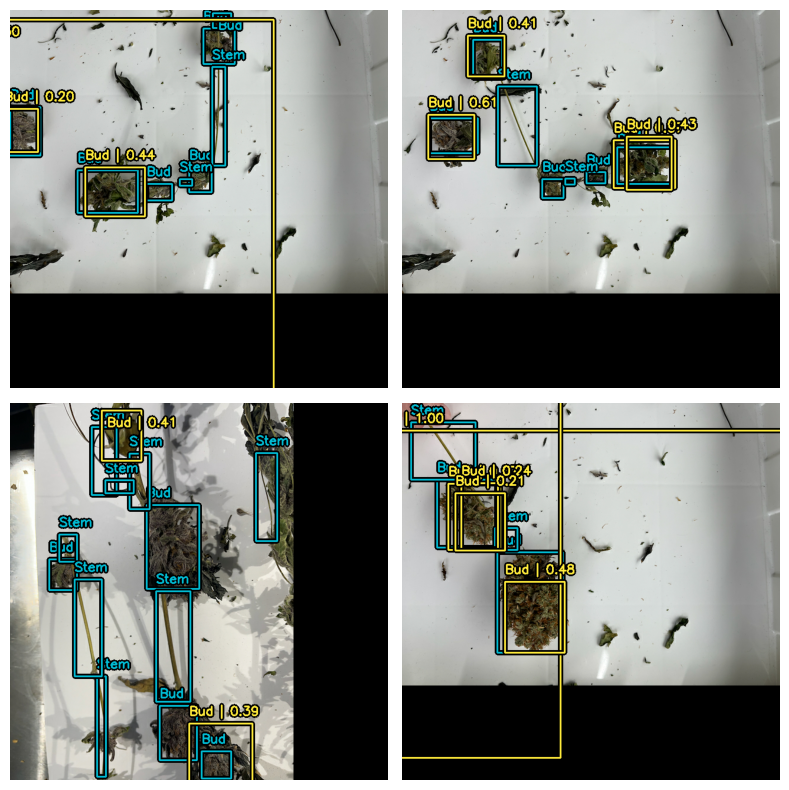

In [19]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")